# Working with Replicate in Pixeltable

Pixeltable's Replicate integration enables you to access Replicate's models via the Replicate API.

### Prerequisites

- A Replicate account with an API token.

### Important notes

- Replicate usage may incur costs based on your Replicate plan.
- Be mindful of sensitive data and consider security measures when integrating with external services.

First you'll need to install required libraries and enter a Replicate API token.

In [ ]:
%pip install -qU pixeltable replicate

In [ ]:
import os
import getpass

if 'REPLICATE_API_TOKEN' not in os.environ:
    os.environ['REPLICATE_API_TOKEN'] = getpass.getpass('Replicate API Token:')

Now let's create a Pixeltable directory to hold the tables for our demo.

In [1]:
import pixeltable as pxt

# Remove the `replicate_demo` directory and its contents, if it exists
pxt.drop_dir('replicate_demo', force=True)
pxt.create_dir('replicate_demo')

Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/asiegel/.pixeltable/pgdata
Created directory 'replicate_demo'.


## Chat completions

Create a Table: In Pixeltable, create a table with columns to represent your input data and the columns where you want to store the results from Replicate.

In [2]:
from pixeltable.functions.replicate import run

# Create a table in Pixeltable and pick a model hosted on Replicate with some parameters

t = pxt.create_table('replicate_demo/chat', {'prompt': pxt.String})

input = {
    'system_prompt': 'You are a helpful assistant.',
    'prompt': t.prompt,
    # These parameters are optional and can be used to tune model behavior:
    'max_tokens': 300,
    'top_p': 0.9,
    'temperature': 0.8
}
t.add_computed_column(output=run(input, ref='meta/meta-llama-3-8b-instruct'))

Created table 'chat'.
Added 0 column values with 0 errors in 0.01 s


No rows affected.

In [3]:
# Parse the response into a new column
t.add_computed_column(response=pxt.functions.string.join('', t.output))

Added 0 column values with 0 errors in 0.02 s


No rows affected.

In [4]:
# Start a conversation
t.insert([{'prompt': 'What foods are rich in selenium?'}])
t.select(t.prompt, t.response).show()

Inserted 1 row with 0 errors in 4.45 s (0.22 rows/s)


prompt,response
What foods are rich in selenium?,"Selenium is an essential mineral that plays a crucial role in our health, and it's great that you're looking to increase your intake. Here are some selenium-rich foods that you can add to your diet: 1. Brazil Nuts: Brazil nuts are one of the richest sources of selenium, with a single nut providing about 80-90 micrograms of selenium. Just be mindful of portion sizes, as they're high in calories too! 2. Fish: Fatty fish like tuna, mackerel, and sardines are good sources of selenium. A 3-oun ...... good source of selenium, with a 3-ounce serving providing about 20-30 micrograms. 5. Chicken: Chicken breast is also a good source of selenium, with a 3-ounce serving providing about 15-20 micrograms. 6. Eggs: Eggs are a good source of selenium, with a large egg providing about 15-20 micrograms. 7. Mushrooms: Certain types of mushrooms, such as shiitake and portobello, are good sources of selenium. A 1-cup serving of cooked mushrooms can provide about 10-15 micrograms of selenium. 8. Garlic:"


## Image generation

Here's an example that shows how to use Replicate's image generation models with Pixeltable. We'll use the FLUX Schnell model.

In [5]:
t = pxt.create_table('replicate_demo/images', {'prompt': pxt.String})

input = {
    'prompt': t.prompt,
    'go_fast': True,
    'megapixels': '1'
}
t.add_computed_column(output=run(input, ref='black-forest-labs/flux-schnell'))

Created table 'images'.
Added 0 column values with 0 errors in 0.01 s


No rows affected.

In [6]:
t.insert([{'prompt': 'Draw a pencil sketch of a friendly dinosaur playing tennis in a cornfield.'}])

Inserted 1 row with 0 errors in 0.99 s (1.01 rows/s)


1 row inserted.

In [7]:
t.select(t.prompt, t.output).collect()

prompt,output
Draw a pencil sketch of a friendly dinosaur playing tennis in a cornfield.,"[""https://replicate.delivery/czjl/nVU0Qp9LxLaENJO0XegI1sezZqVsGEJgUzp9THFmeFB1xPAsA/out-0.webp""]"


We see that Replicate returns our image as an array containing a single URL. To turn it into an actual image, we cast the string to type `pxt.Image` in a new computed column:

Added 1 column value with 0 errors in 0.02 s (53.36 rows/s)


image
""

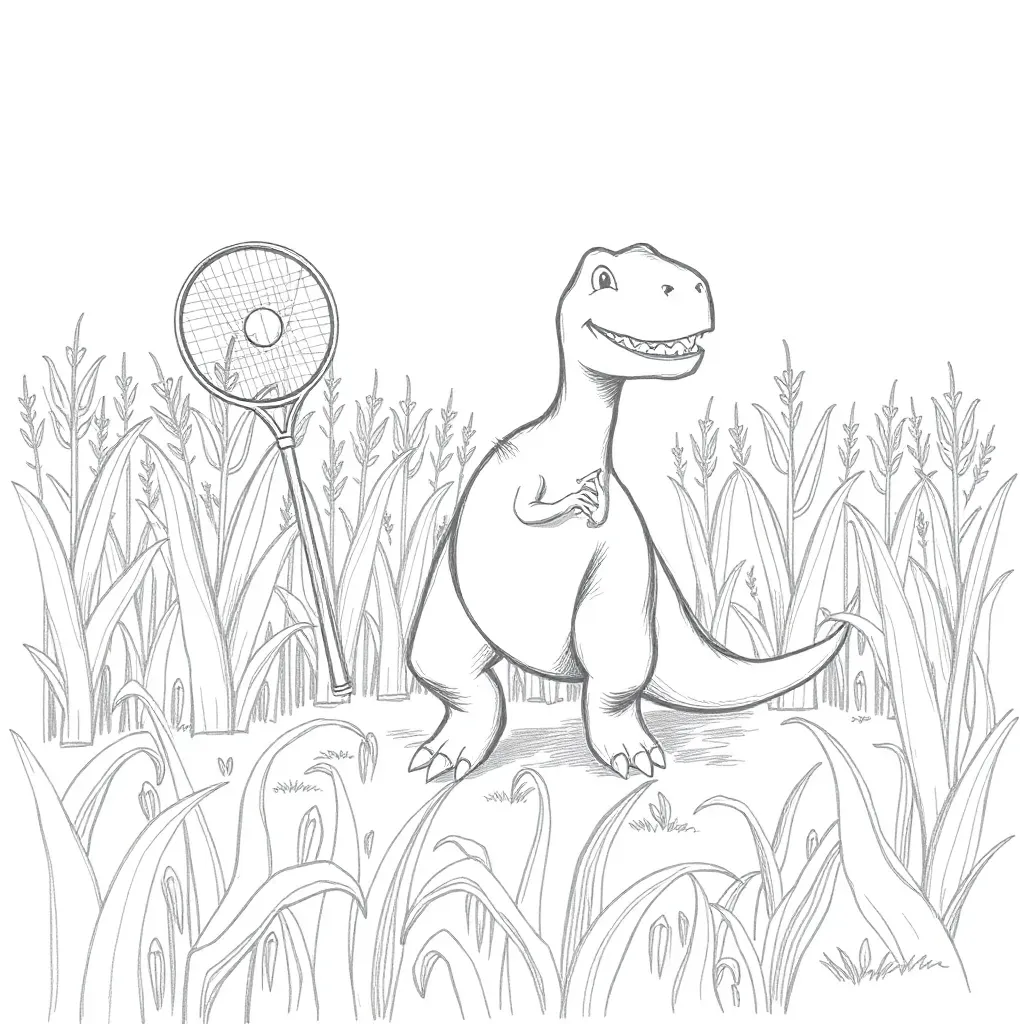

In [8]:
t.add_computed_column(image=t.output[0].astype(pxt.Image))
t.select(t.image).collect()

### Learn more

To learn more about advanced techniques like RAG operations in Pixeltable, check out the [RAG Operations in Pixeltable](https://docs.pixeltable.com/howto/use-cases/rag-operations) tutorial.

If you have any questions, don't hesitate to reach out.